# **Русско-английский переводчик с использованием трансформера**

Однажды я заметила, что переводчик некорректно работает с длинными текстами, хотя я не была уверена, что это типично для всех длинных текстов, но интуитивно я вводила короткие предложения в Google Translate. Теперь я понимаю, почему это было так - это все из-за RNN. С 2017 года Google Translate перешел на архитектуру трансформеров, поэтому переводы стали лучше. Я решила разобраться в том как они работают и рассмотрела следующее руководство: **https://keras.io/examples/nlp/neural_machine_translation_with_transformer/.**


**Сначала подключим необходимые библиотеки**

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import string
import re
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

**БД переводов я взяла с Anki (https://www.manythings.org/anki/) и сделала следующий датафрейм:**

In [105]:
en_rus_df = pd.read_csv('rus.txt', sep='\t', usecols=[0, 1])
en_rus_df.columns = ['en', 'rus']
en_rus_df.head()

,en,rus
0,Go.,Иди.
1,Go.,Идите.
2,Hi.,Здравствуйте.
3,Hi.,Привет!
4,Hi.,Хай.


In [106]:
print("Размер датафрейма: ", en_rus_df.shape)

Размер датафрейма:  (438014, 2)


**Данная модель является упрощенной, поэтому приводим тексты в нижний регистр и убираем пунктуацию. Для текстов на английском переписываем сокращения в формальном виде (официальном виде):**

In [107]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def clean_text(text):
  text = text.lower() # приводим в нижний регистр
  if language == 'en':
    text = ' '.join([contractions[word] if word in contractions else word for word in text.split()]) # приводим к формальному стилю английский текст
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # убираем пунктуацию
  return text

for language in en_rus_df:
  en_rus_df[language] = en_rus_df[language].apply(lambda text : clean_text(text))

en_rus_df.head()

,en,rus
0,go,иди
1,go,идите
2,hi,здравствуйте
3,hi,привет
4,hi,хай


**Таким датасет оставлять тоже нельзя. Архитектура декодера трансформера требует чтобы у целевого текста (в нашем случае английского) были токены начала и конца, поэтому добавим их.**

In [108]:
en_rus_df['en'] = en_rus_df['en'].apply(lambda i : "[start] " + i + "[end]")

In [109]:
en_rus_df.head()

,en,rus
0,[start] go [end],иди
1,[start] go [end],идите
2,[start] hi [end],здравствуйте
3,[start] hi [end],привет
4,[start] hi [end],хай


**Определим распределение длин текстов**


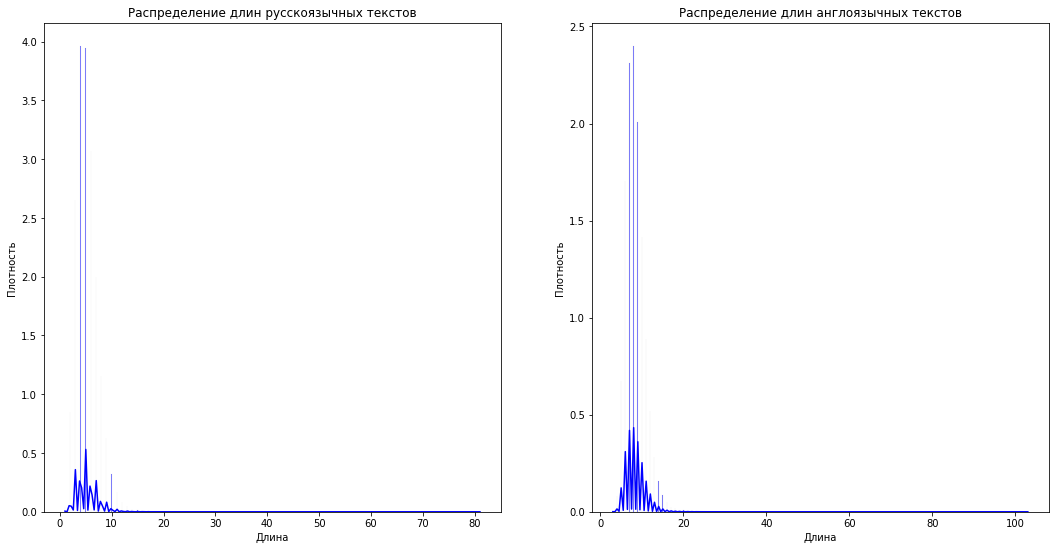

In [110]:
plt.figure(figsize=(18, 9))
plt.subplot(121)
sns.histplot(en_rus_df['rus'].str.split().apply(len), color="blue", kde=True, stat="density")
plt.title('Распределение длин русскоязычных текстов')
plt.xlabel('Длина')
plt.ylabel('Плотность')

plt.subplot(122)
sns.histplot(en_rus_df['en'].str.split().apply(len), color="blue", kde=True, stat="density")
plt.title('Распределение длин англоязычных текстов')
plt.xlabel('Длина')
plt.ylabel('Плотность')
plt.show()

Из графиков видно, что достаточно ограничиться текстами длиной до 20 символов

In [111]:
seq_len = 20

**Разбиваем данные на тренировочные, валидационные и тестовые выборки**

In [112]:
train_df, test_df = train_test_split(en_rus_df, test_size=0.2, shuffle=True, random_state=100)

train_df = train_df.reset_index(drop=True)

val_df, test_df = train_test_split(test_df, test_size=0.5, shuffle=True, random_state=100)

test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print("Размер тренировочного датафрейма:", train_df.shape)
print("Размер тестового датафрейма:", test_df.shape)
print("Размер валидационного датафрейма:", val_df.shape)

Размер тренировочного датафрейма: (350411, 2)
Размер тестового датафрейма: (43802, 2)
Размер валидационного датафрейма: (43801, 2)


In [113]:
test_df.head()

,en,rus
0,[start] i got it for free [end],я получил это бесплатно
1,[start] do not tell tom that [end],не говорите об этом тому
2,[start] i am glad to hear you say that [end],я рада слышать что вы говорите это
3,[start] get me the evidence [end],приведи улики
4,[start] how much does this shirt cost [end],сколько стоит эта рубашка


**Делаем словарь**

In [114]:
en_rus_list = list(en_rus_df.to_records(index=False)) # представляем en_rus_df как list of tuples

In [115]:
en_rus_list[:5]

[('[start] go [end]', 'иди '),
 ('[start] go [end]', 'идите '),
 ('[start] hi [end]', 'здравствуйте '),
 ('[start] hi [end]', 'привет '),
 ('[start] hi [end]', 'хай ')]

In [116]:
vocab_size = 15000 # пусть будет так
batch_size = 64 # пусть будет так

strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
  return tf.strings.regex_replace(input_string, "[%s]" % re.escape(strip_chars), "")

rus_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=seq_len,)

eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=seq_len + 1,
    standardize=custom_standardization,)

train_rus_texts = [pair[1] for pair in en_rus_list]
train_eng_texts = [pair[0] for pair in en_rus_list]
rus_vectorization.adapt(train_rus_texts)
eng_vectorization.adapt(train_eng_texts)

In [117]:
rus_vocabulary = rus_vectorization.get_vocabulary()
print("Первые 5 токенов русского словаря: ", rus_vocabulary[:5])

Первые 5 токенов русского словаря:  ['', '[UNK]', 'я', 'не', 'том']


In [118]:
eng_vocabulary = eng_vectorization.get_vocabulary()
print("Первые 5 токенов английского словаря: ", eng_vocabulary[:5])

Первые 5 токенов английского словаря:  ['', '[UNK]', '[start]', '[end]', 'i']


**Для применения архитектуры трансформера нам нужно представить тренировочные и тестовые датафреймы в виде датасетов Tensorflow (https://www.tensorflow.org/api_docs/python/tf/data/Dataset)**

In [119]:
train_list = list(train_df.to_records(index=False)) # представляем train_df как list of tuples
test_list = list(test_df.to_records(index=False)) # представляем test_df как list of tuples

In [120]:
test_list[:5]

[('[start] i got it for free [end]', 'я получил это бесплатно '),
 ('[start] do not tell tom that [end]', 'не говорите об этом тому '),
 ('[start] i am glad to hear you say that [end]', 'я рада слышать  что вы говорите это '),
 ('[start] get me the evidence [end]', 'приведи улики '),
 ('[start] how much does this shirt cost [end]', 'сколько стоит эта рубашка ')]

In [121]:
def format_dataset(eng, rus):
    eng = eng_vectorization(eng)
    rus = rus_vectorization(rus)
    return ({"encoder_inputs": rus, "decoder_inputs": eng[:, :-1],}, eng[:, 1:])


def make_dataset(pairs):
    eng_texts, rus_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    rus_texts = list(rus_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, rus_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_list)
test_ds = make_dataset(test_list)

In [122]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


**Приступим к созданию модели и вспомним что такое трансформер**

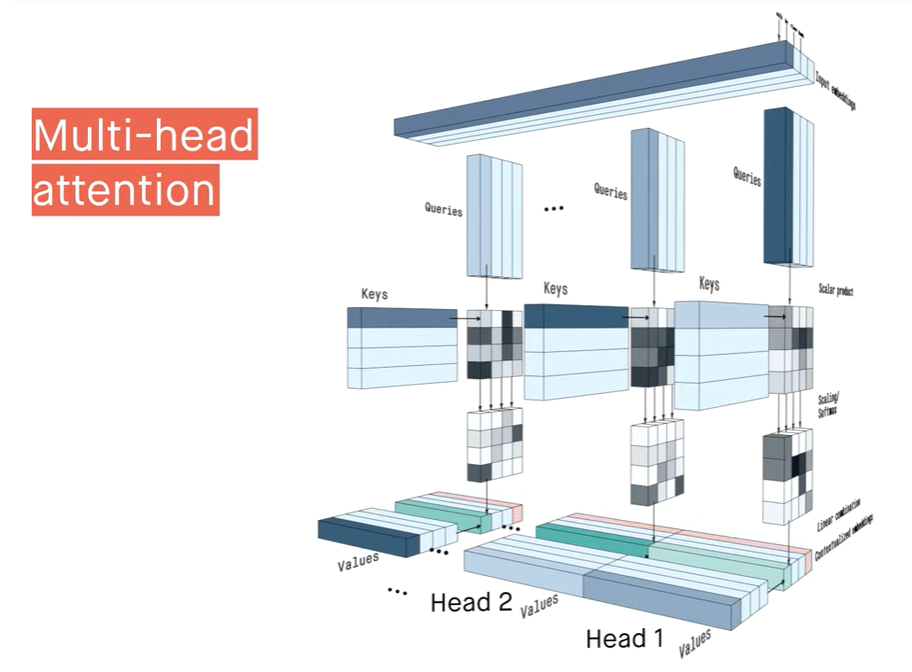

In [123]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [124]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(seq_len, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(seq_len, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")

In [125]:
epochs = 30  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.fit(train_ds, epochs=epochs, validation_data=test_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_6 (Positi  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 onalEmbedding)                                                                                   
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_3 (Transfo  (None, None, 256)   3155456     ['positional_embedding_

In [129]:
eng_index_lookup = dict(zip(range(len(eng_vocabulary)), eng_vocabulary))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = rus_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = eng_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = eng_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [138]:
results = []
for _ in range(10):
    input_sentence = random.choice(en_rus_list)
    test_rus_texts = input_sentence[1]
    test_eng_texts = input_sentence[0]
    translated = decode_sequence(test_rus_texts)
    results.append({'rus': test_rus_texts, 'en': translated, 'en_target': test_eng_texts})

results_df = pd.DataFrame(results)
results_df

,rus,en,en_target
0,я раньше жил в другом месте,[start] i used to live in a place [end],[start] i used to live someplace else [end]
1,что то должно быть произошло в бостоне том ка...,[start] something tom must be true in boston [...,[start] something must have happened in boston...
2,тому удалось купить то что он хотел,[start] tom took a lot that he wanted to buy [...,[start] tom was able to buy what he wanted [end]
3,поедим по дороге,[start] there are on the way [end],[start] we will eat on the way [end]
4,том хотел купить мэри шубу,[start] tom wanted to buy mary a [UNK] [end],[start] tom wanted to buy a fur coat for mary ...
5,два из трёх — неплохо,[start] two of two is bad [end],[start] two out of three is not bad [end]
6,неважно остаёшься ты или нет,[start] it does not care whether you are not [...,[start] it does not matter if you stay or not ...
7,том думает что вы делаете это нарочно,[start] tom thinks you are doing that on monda...,[start] tom thinks you are doing it on purpose...
8,том это поймёт,[start] tom will understand it [end],[start] tom will understand this [end]
9,нам пойти помочь,[start] we have to go help [end],[start] should we go help [end]
